# Web Mining Final Project - Movie Recommendation System

**By Wenjie Zhang**
**,Tarun**

## Table of Content:

* Objective

* Explorative Data Analysis
    -  Data loading
    -  Data viewing
    -  Data cleaning
    
* Recommendation models
    -  Memory based Collaborative Filtering
    -  Model-based Collaborative Filtering

# Objective
<br>
Learn from data and recommend best TV shows to users, based on self & others behaviour
<br>
<img src="https://cdn.vox-cdn.com/thumbor/JgqnIcQk9lP4v_1X5LBegKKiB4Q=/0x0:1400x787/920x613/filters:focal(588x282:812x506):format(webp)/cdn.vox-cdn.com/uploads/chorus_image/image/66793462/freefiretv.0.png"/>

# Explorative Data Analysis

## Data Format & Data Importing
### rating.csv

* Movie ID (as first line of each new movie record / file)
* UserID
* Rating (1 to 5)
* Date they gave the ratings

### Movies.csv
- Movie ID
- title
- genres

## Importing the dataset

In [1]:
import pandas as pd
import numpy as np
import math
import re
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("ticks")

In [2]:
column_names = ['user_id', 'movie_id', 'rating', 'timestamp']
df = pd.read_csv('u.data', sep='\t', names=column_names)
df['rating'] = df['rating'].astype(float)

print('Dataset 1 shape: {}'.format(df.shape))
print('-Dataset examples-')
print(df.iloc[::50000, :])
df.head()

Dataset 1 shape: (100003, 4)
-Dataset examples-
        user_id  movie_id  rating  timestamp
0             0        50     5.0  881250949
50000       537       385     2.0  886032098
100000      276      1090     1.0  874795795


,user_id,movie_id,rating,timestamp
0,0,50,5.0,881250949
1,0,172,5.0,881250949
2,0,133,1.0,881250949
3,196,242,3.0,881250949
4,186,302,3.0,891717742


### Loading the movie data

In [3]:
column_names = ['movie_id', 'title', 'genres']
movie_titles = pd.read_csv("small/movies.csv", header=0, names=column_names)
movie_titles.head()

,movie_id,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
df = pd.merge(df,movie_titles,on='movie_id')
df.head()

,user_id,movie_id,rating,timestamp,title,genres
0,0,50,5.0,881250949,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
1,290,50,5.0,880473582,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
2,79,50,4.0,891271545,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
3,2,50,5.0,888552084,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
4,8,50,5.0,879362124,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


## Visualization Imports

Let's create a ratings dataframe with average rating and number of ratings:

In [5]:
# Mean of Rating by title
pd.DataFrame(df.groupby('title')['rating'].mean().sort_values(ascending=False).head())

,rating
title,
"Good, the Bad and the Ugly, The (Buono, il brutto, il cattivo, Il) (1966)",5.0
Steel (1997),5.0
"Thin Blue Line, The (1988)",5.0
Grosse Pointe Blank (1997),5.0
Gattaca (1997),5.0


In [6]:
# Count of Rating by title
pd.DataFrame(df.groupby('title')['rating'].count().sort_values(ascending=False).head())

,rating
title,
"Usual Suspects, The (1995)",584
"Kid in King Arthur's Court, A (1995)",509
City Hall (1996),508
Mighty Morphin Power Rangers: The Movie (1995),507
"Perez Family, The (1995)",485


In [7]:
ratings = pd.DataFrame(df.groupby('title')['rating'].mean())
ratings['num of ratings'] = pd.DataFrame(df.groupby('title')['rating'].count())
ratings.head()

,rating,num of ratings
title,,
'Til There Was You (1997),2.548387,31
1-900 (06) (1994),3.384615,13
101 Dalmatians (1996),4.200000,5
12 Angry Men (1957),4.047619,21
187 (One Eight Seven) (1997),1.666667,3


In [8]:
ratings.sort_values('num of ratings',ascending=False).head(10)

,rating,num of ratings
title,,
"Usual Suspects, The (1995)",4.359589,584
"Kid in King Arthur's Court, A (1995)",3.803536,509
City Hall (1996),4.155512,508
Mighty Morphin Power Rangers: The Movie (1995),4.007890,507
"Perez Family, The (1995)",3.156701,485
Natural Born Killers (1994),3.441423,478
Toy Story (1995),3.878319,452
Quiz Show (1994),3.631090,431
"Boys of St. Vincent, The (1992)",3.438228,429


### Total Movie Count  and Rating count

In [9]:
p = df.groupby('rating')['rating'].agg(['count'])

# get movie counta
movie_count = df.isnull().sum()[1]

# get customer count
cust_count = df['user_id'].nunique() - movie_count

# get rating count
rating_count = df['user_id'].count() - movie_count

print('Total pool: {:,} Movies, {:,} customers, {:,} ratings given'.format(movie_count, cust_count, rating_count))

Total pool: 0 Movies, 944 customers, 80,410 ratings given


<AxesSubplot:title={'center':'Num of rating distribution'}>

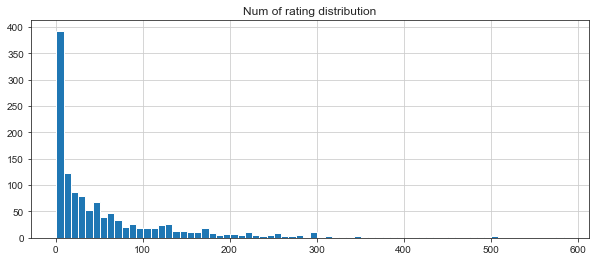

In [10]:
plt.figure(figsize=(10,4))
plt.title("Num of rating distribution")
ratings['num of ratings'].hist(bins=70)

We can see only few movies are popular amoung viewer

### Rating distribution

<AxesSubplot:title={'center':'rating distribution'}>

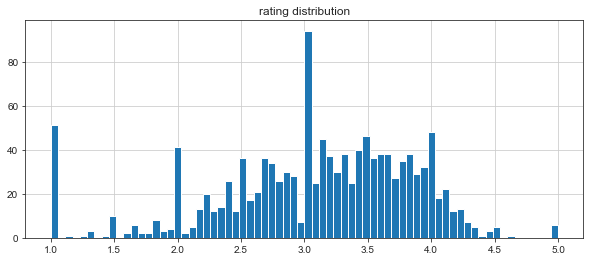

In [11]:
plt.figure(figsize=(10,4))
plt.title("rating distribution")
ratings['rating'].hist(bins=70)

### Rating Correlation

Text(1, 1, 'It shows more ratings it has, the better rating it is')

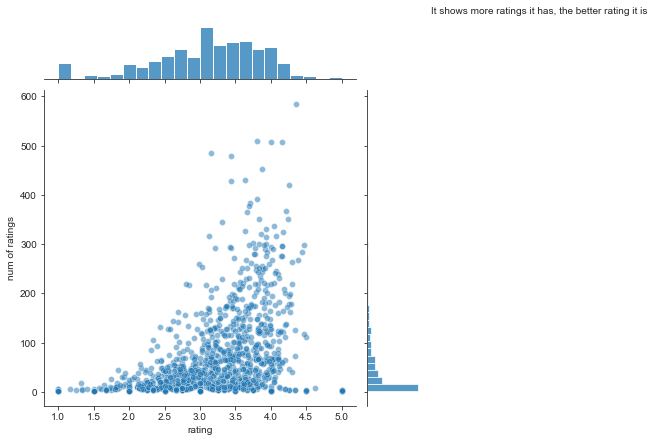

In [12]:
sns.jointplot(x='rating',y='num of ratings',data=ratings,alpha=0.5)
plt.figtext(1, 1
            , "It shows more ratings it has, the better rating it is")

## Model Used

**Collaborative Filtering (CF)**. 

* Collaborative filtering produces recommendations based on the knowledge of users’ attitude to items, that is it uses the "wisdom of the crowd" to recommend items.

## Memory-Based Collaborative Filtering

Memory-Based Collaborative Filtering approaches can be divided into two main sections: **user-item filtering** and **item-item filtering**. 

A *user-item filtering* will take a particular user, find users that are similar to that user based on similarity of ratings, and recommend items that those similar users liked. 

In contrast, *item-item filtering* will take an item, find users who liked that item, and find other items that those users or similar users also liked. It takes items and outputs other items as recommendations. 

* *Item-Item Collaborative Filtering*: “Users who liked this item also liked …”
* *User-Item Collaborative Filtering*: “Users who are similar to you also liked …”

## Data pre-process

### Step 1 splitting the data
The training matrix contains 75% of the ratings and the testing matrix contains 25% of the ratings.

In [15]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(df, test_size=0.25)
print(" Training data {} rows  testing data {} rows ".format(train_data.shape[0], test_data.shape[0]))

 Training data 75002 rows  testing data 25001 rows 


### Step 2 Generate MovieID-User Matrix

In [16]:
n_users = df.user_id.nunique()
n_movies = df.movie_id.nunique()

print('Num. of Users: '+ str(n_users))
print('Num of Movies: '+str(n_movies))

Num. of Users: 944
Num of Movies: 1682


### Create two user-item matrices, one for training and another for testing

In [17]:
#Create two user-item matrices, one for training and another for testing
train_data_matrix = np.zeros((n_users, n_movies))
for line in train_data.itertuples():
    train_data_matrix[line[1]-1, line[2]-1] = line[3]

test_data_matrix = np.zeros((n_users, n_movies))
for line in test_data.itertuples():
    test_data_matrix[line[1]-1, line[2]-1] = line[3]

In [18]:
from sklearn.metrics.pairwise import pairwise_distances
user_similarity = pairwise_distances(train_data_matrix, metric='cosine')
item_similarity = pairwise_distances(train_data_matrix.T, metric='cosine')

We have already created similarity matrices: `user_similarity` and `item_similarity` and therefore we can make a prediction by applying following formula for user-based CF:

<img class="aligncenter size-thumbnail img-responsive" src="https://latex.codecogs.com/gif.latex?\hat{x}_{k,m}&space;=&space;\bar{x}_{k}&space;&plus;&space;\frac{\sum\limits_{u_a}&space;sim_u(u_k,&space;u_a)&space;(x_{a,m}&space;-&space;\bar{x_{u_a}})}{\sum\limits_{u_a}|sim_u(u_k,&space;u_a)|}"/>

In [19]:
def predict(ratings, similarity, type='user'):
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        #You use np.newaxis so that mean_user_rating has same format as ratings
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis]) 
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])     
    return pred

In [20]:
item_prediction = predict(test_data_matrix, item_similarity, type='item')
user_prediction = predict(test_data_matrix, user_similarity, type='user')

### Evaluation
*Root Mean Squared Error (RMSE)*. 
<img src="https://latex.codecogs.com/gif.latex?RMSE&space;=\sqrt{\frac{1}{N}&space;\sum&space;(x_i&space;-\hat{x_i})^2}" title="RMSE =\sqrt{\frac{1}{N} \sum (x_i -\hat{x_i})^2}" />


In [21]:
from sklearn.metrics import mean_squared_error
from math import sqrt
def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten() 
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, ground_truth))

In [22]:
print('User-based CF RMSE: ' + str(rmse(user_prediction, test_data_matrix)))
print('Item-based CF RMSE: ' + str(rmse(item_prediction, test_data_matrix)))

User-based CF RMSE: 3.5137900910062787
Item-based CF RMSE: 3.628710071850567


# Model-based Collaborative Filtering
MovieLen datasetis a very sparse matrix, with a lot of dimensions, by doing matrix factorization we can restructure the  user-item matrix into low-rank structure, and we can represent the matrix by the multiplication of two low-rank matrices, where the rows contain the latent vector. You fit this matrix to approximate your original matrix, as closely as possible, by multiplying the low-rank matrices together, which fills in the entries missing in the original matrix.

Let's calculate the sparsity level

In [23]:
sparsity=round(1.0-len(df)/float(n_users*n_movies),3)
print('The sparsity level of MovieLens100K is ' +  str(sparsity*100) + '%')

The sparsity level of MovieLens100K is 93.7%


### SVD
A well-known matrix factorization method is **Singular value decomposition (SVD)**. Collaborative Filtering can be formulated by approximating a matrix `X` by using singular value decomposition. The winning team at the Netflix Prize competition used SVD matrix factorization models to produce product recommendations.
The general equation can be expressed as follows:
<img src="https://latex.codecogs.com/gif.latex?X=USV^T" title="X=USV^T" />
Given `m x n` matrix `X`:
* *`U`* is an *`(m x r)`* orthogonal matrix
* *`S`* is an *`(r x r)`* diagonal matrix with non-negative real numbers on the diagonal
* *V^T* is an *`(r x n)`* orthogonal matrix

In [24]:
import scipy.sparse as sp
from scipy.sparse.linalg import svds

#get SVD components from train matrix. Choose k.
u, s, vt = svds(train_data_matrix, k = 20)
s_diag_matrix=np.diag(s)
X_pred = np.dot(np.dot(u, s_diag_matrix), vt)
print('SVD MSE: ' + str(rmse(X_pred, test_data_matrix)))

SVD MSE: 2.733627615437357


### Using SVD to predict rating

In [25]:
user_ratings_mean = np.mean(train_data_matrix, axis=1)
all_user_predicted_ratings = np.dot(np.dot(u, s_diag_matrix), vt) + user_ratings_mean.reshape(-1, 1)
preds = pd.DataFrame(all_user_predicted_ratings)
preds.head()

,0,1,2,3,4,5,6,7,8,9,...,1672,1673,1674,1675,1676,1677,1678,1679,1680,1681
0,4.717720,1.870983,1.003397,2.915846,1.618432,0.624740,3.926589,2.916857,2.731469,1.404435,...,0.443921,0.448870,0.441886,0.444214,0.480286,0.444462,0.435646,0.440054,0.473643,0.448870
1,2.249814,-0.116180,0.097697,0.265975,0.035908,0.221396,1.057234,0.452258,1.658680,0.474317,...,0.110437,0.092747,0.083516,0.086593,0.103167,0.095072,0.099723,0.097398,0.091583,0.092747
2,0.034063,0.063109,0.066372,-0.054309,0.050367,0.038540,-0.062807,0.075996,-0.129555,-0.066775,...,0.055430,0.058859,0.067043,0.064315,0.053201,0.065150,0.077733,0.071441,0.067648,0.058859
3,0.470645,-0.046903,0.087925,-0.083414,0.229558,0.000995,0.575703,-0.281510,0.129658,-0.216193,...,0.050367,0.052913,0.050470,0.051285,0.057442,0.057942,0.068000,0.062971,0.042045,0.052913
4,4.035206,1.614486,0.657301,1.375850,0.147964,-0.040469,2.630014,1.000684,-0.166798,0.620716,...,0.220439,0.222949,0.186534,0.198672,0.208345,0.221860,0.219682,0.220771,0.208219,0.222949


### View a real application to generate recommended movies


[Moive Recommender](https://wenjiemovierecommender.herokuapp.com/)

# Thank you for viewing